## Using Clifford algebra to reduce the circuit depth for generating Hamiltonian eigenstates 


*Marc Maußner, Thierry Kaldenbach, Raphael Kopp & Lea Marlen Rektorschek*

## Introduction:

The Hamiltonian mixer approach is a technique used in quantum computing to encode and manipulate information within a quantum system.
This approach is particularly useful in the context of chemistry and material science, where the Hamiltonian mixer is utilized to evolve the system gradually towards a desired state $H_0$ that represents the solution to a given hard-to solve problem [1].
To do so, we define our simulation Hamiltonian like this: <br>
$H = s(t) H_0 + (1-s(t)) H_{mixer}$, where $s$ is the coupling strength between $H_0$ and $H_{mixer}$, $H_0$ defines the Hamiltonian ground state we want to know and  $H_{mixer}$ is the Hamiltonian to adiabatically evolve to $H_0$. 
The gradual transformation of $H_{mixer} \Rightarrow H_0$ is done by increasing $s$ over time. Due to the adiabatic theorem, we can start with the efficient to prepare ground state of $H_{mixer}$ and evolve it over time to obtain the ground state of $H_0$. If the time evolution is discretized into sufficiently small enough time steps, the time evolution of one time step can be performed with the time evolution operator 
$ e^{-\frac{i}{2} H \Delta t}$. However, implementing this time-evolution operator as a quantum circuit generally requires a significant number of two qubit operations. Transpiling circuits with large numbers of two qubit operations for a real quantum computer usually leads to a high depth of the physically executed quantum circuit causing higher error rates and exceeding coherence time. To circumvent this problem, we develop an approximation to reduce the number of two qubit operations and therewith the depth of the quantum circuit.

## Idea

The core idea of our approach is to approximate the quantum circuit representing the time evolution of our initial state with a stabilizer circuit. Stabilizer circuits are circuits based on Clifford gates and can be fully described by means of the generators $CNOT, H, S$. 
The advantage of this is that it allows to transform to a graph state representation which efficiently reduces the number of two qubit operations and therewith the depth of the quantum circuit. Additionally, due to the Gottesman-Knill theorem stabilizer circuits can be efficiently simulated on a classical computer [2] which allows to shift parts of the computation from the quantum computation to a classical simulation. <br>
A detailed description of the individual steps can be found further down in this notebook.

<br>


[1]: Berry, D.W., Kieferová, M., Scherer, A. et al. Improved techniques for preparing eigenstates of fermionic Hamiltonians. npj Quantum Inf 4, 22 (2018). https://doi.org/10.1038/s41534-018-0071-5 <br>
[2]: Anders, S. and Briegel, H. J., “Fast simulation of stabilizer circuits using a graph-state representation”, Physical Review A, vol. 73, no. 2, 2006. doi:10.1103/PhysRevA.73.022334

## "Naive"/default solution and motivation for our problem

As a first example we will try to solve simple Ising models with the Quantum Approximate Optimization Algorithm (QAOA)[3]. The Ising Hamiltionins we consider for this are $H_{0,2} = Z_0Z1$ and $H{0,6} = Z_0Z_1Z_2Z_3Z_4Z_5$. <br>

[3] Edward Farhi, Jeffrey Goldstone, Sam Gutmann, “A Quantum Approximate Optimization Algorithm”, 2014, https://doi.org/10.48550/arXiv.1411.4028

In [316]:
# Importing all the parts we will need.
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit_optimization.applications import Tsp
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import algorithm_globals
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit.circuit import Parameter
from qiskit.providers.fake_provider import FakeHanoiV2, FakeTorontoV2, FakeMumbaiV2
from qiskit.opflow import Z
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import random_clifford
from qiskit.quantum_info import Clifford
from qiskit.circuit.library import GraphState as GS
from qiskit.quantum_info import StabilizerState
from qiskit.quantum_info import Pauli
from qiskit.quantum_info import SparsePauliOp

import graph_state
from graph_state import GraphState 

from qiskit import execute
from qiskit import Aer


import warnings
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

warnings.filterwarnings("ignore")

import math

pi = math.pi


Lets start with a simple simulation neglecting noise for 2 qubits, with $H_0 = Z_0Z_1$ and $H_{mixer} = X_0X_1$.

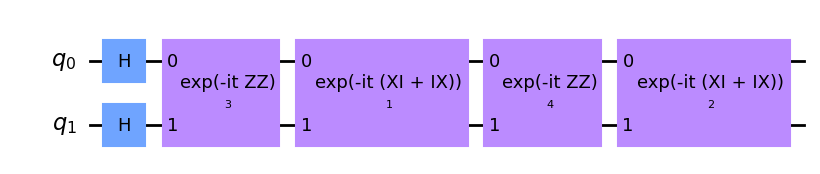

In [317]:
# define qaoa
H0 = Z^Z
qaoa = QAOA(reps = 2)
circuit = qaoa.construct_circuit([1,2,3,4], H0)[0] # use beta1=1, beta2=2, gamma1=3, gamma2=4
circuit.draw('mpl')

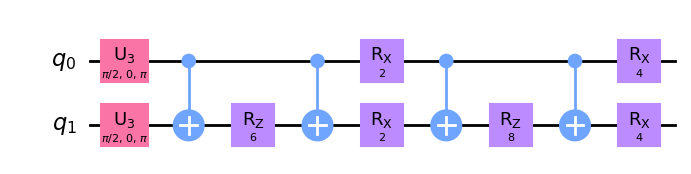

In [318]:
circuit.decompose().decompose().draw('mpl')

In [319]:
# run on qasm simulator
seed = 1234
algorithm_globals.random_seed = seed
quantum_instance = QuantumInstance(Aer.get_backend("qasm_simulator"), 
                                   seed_simulator=seed, 
                                   seed_transpiler=seed, 
                                   shots=1024
                                  )
qaoa = QAOA(optimizer = COBYLA(), quantum_instance=quantum_instance)
result = qaoa.compute_minimum_eigenvalue(H0)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 29,
    'eigenstate': {'01': 0.7132945131570829, '10': 0.7008644216251814},
    'eigenvalue': (-0.9999999999999999+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(γ[0]): 0.7970560548034817,
                              ParameterVectorElement(β[0]): 7.465765403323452},
    'optimal_point': array([7.4657654 , 0.79705605]),
    'optimal_value': -0.9999999999999999,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 0.20541930198669434}


In [320]:
print('without noise, eigenvalue = ',result.eigenvalue.real)

without noise, eigenvalue =  -0.9999999999999999


Now, lets run on a fake device to investigate the influence of noise. 

In [321]:
# run on fake device
seed = 1234
algorithm_globals.random_seed = seed
quantum_instance = QuantumInstance(FakeTorontoV2(), 
                                   seed_simulator=seed, 
                                   seed_transpiler=seed, 
                                   shots=1024
                                  )
qaoa = QAOA(optimizer = COBYLA(), quantum_instance=quantum_instance)
result = qaoa.compute_minimum_eigenvalue(H0)
print(result)
#output means more less noise -> states "00", "01", "10", "11"

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 28,
    'eigenstate': {   '00': 0.3217384419058438,
                      '01': 0.6358434359179939,
                      '10': 0.6540140480142609,
                      '11': 0.2538762001448738},
    'eigenvalue': (-0.6640624999999999+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(γ[0]): -0.8117154355956047,
                              ParameterVectorElement(β[0]): 6.688710370200932},
    'optimal_point': array([ 6.68871037, -0.81171544]),
    'optimal_value': -0.6640624999999999,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 2.735217809677124}


In [322]:
print('with noise, eigenvalue = ',result.eigenvalue.real)

with noise, eigenvalue =  -0.6640624999999999


We see the true Eigenvalue is -1, where on our fake device we find -0.66. <br>
Let's try the same for 6 qubits.

Where $H_{0} = Z_0Z_1Z_2Z_3Z_4Z_5$ 
and  $H_{mixer} =   X_0X_1X_2X_3X_4X_5$ <br>
We know the solution, the Eigenvalue should be +/- 1.

Starting again neglecting noise.

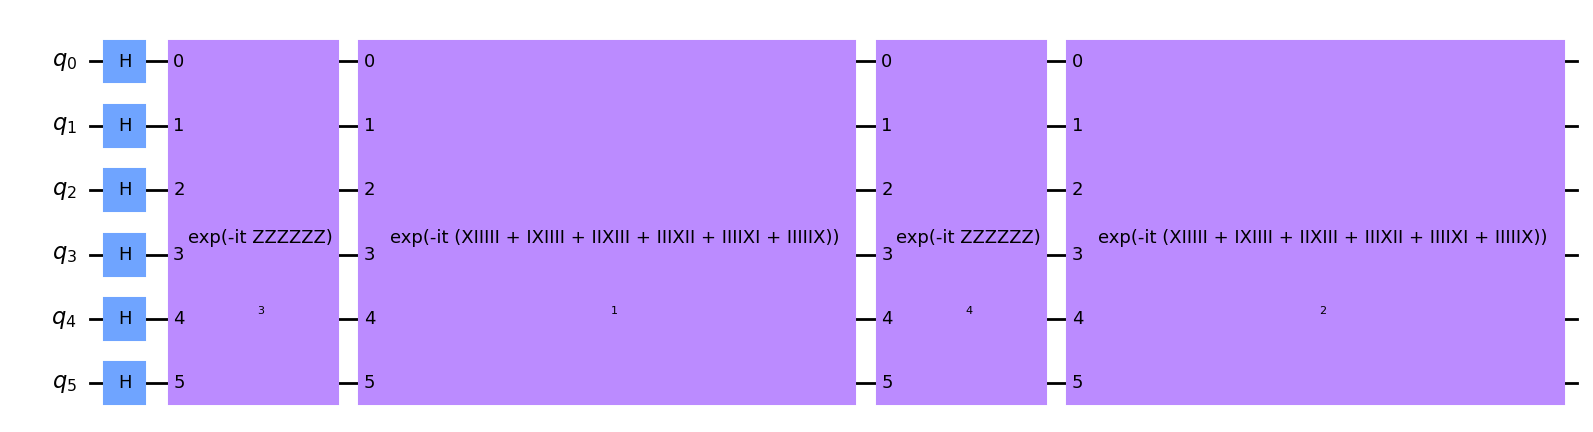

In [323]:
# define qaoa
H0 = Z^Z^Z^Z^Z^Z
qaoa = QAOA(reps = 2)
circuit = qaoa.construct_circuit([1,2,3,4],H0)[0] # use beta, gamma,...
circuit.draw('mpl')

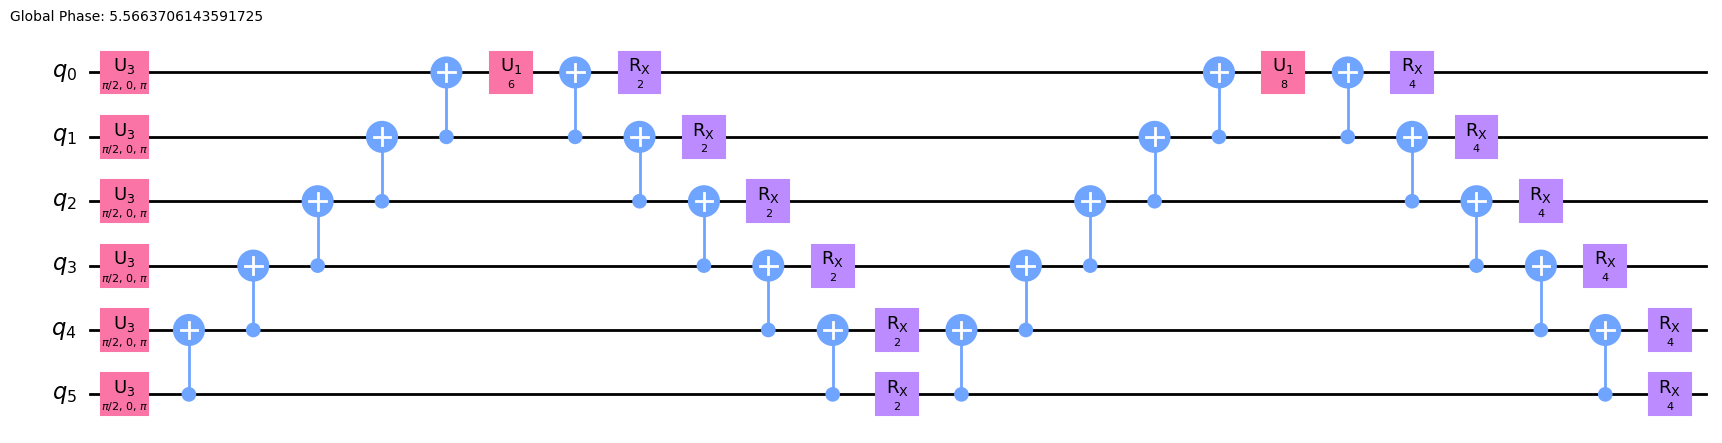

In [324]:
circuit.decompose().decompose().draw('mpl')

In [325]:
# run on qasm simulator
seed = 1234
algorithm_globals.random_seed = seed
quantum_instance = QuantumInstance(Aer.get_backend("qasm_simulator"), 
                                   seed_simulator=seed, 
                                   seed_transpiler=seed, 
                                   shots=1024
                                  )
qaoa = QAOA(optimizer = COBYLA(), quantum_instance=quantum_instance)
result = qaoa.compute_minimum_eigenvalue(H0)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 32,
    'eigenstate': {   '000000': 0.05412658773652741,
                      '000001': 0.1795175827043134,
                      '000010': 0.1875,
                      '000100': 0.1795175827043134,
                      '000101': 0.05412658773652741,
                      '000110': 0.05412658773652741,
                      '000111': 0.19764235376052372,
                      '001000': 0.1795175827043134,
                      '001001': 0.04419417382415922,
                      '001010': 0.03125,
                      '001011': 0.15625,
                      '001101': 0.17399263633843817,
                      '001110': 0.16828640022295324,
                      '001111': 0.03125,
                      '010000': 0.14986973510352247,
                      '010010': 0.03125,
                      '010011': 0.1767766952966369,
                      '010101': 0.17399263633843817,
                      '010110': 0.18221724

In [326]:
print('without noise, eigenvalue = ',result.eigenvalue.real)

without noise, eigenvalue =  -0.935546875


Same procedure as above, now run it on a fake noisy device.

In [327]:
# run on fake device
seed = 1234
algorithm_globals.random_seed = seed
quantum_instance = QuantumInstance(FakeTorontoV2(), 
                                   seed_simulator=seed, 
                                   seed_transpiler=seed, 
                                   shots=1024
                                  )
qaoa = QAOA(optimizer = COBYLA(), quantum_instance=quantum_instance)
result = qaoa.compute_minimum_eigenvalue(H0)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 30,
    'eigenstate': {   '000000': 0.11267347735824966,
                      '000001': 0.15934435979977452,
                      '000010': 0.14657549249448218,
                      '000011': 0.11267347735824966,
                      '000100': 0.12103072956898178,
                      '000101': 0.09882117688026186,
                      '000110': 0.10364452469860624,
                      '000111': 0.1711632992203644,
                      '001000': 0.13975424859373686,
                      '001001': 0.10364452469860624,
                      '001010': 0.09882117688026186,
                      '001011': 0.13258252147247765,
                      '001100': 0.08838834764831845,
                      '001101': 0.14986973510352247,
                      '001110': 0.15625,
                      '001111': 0.07654655446197431,
                      '010000': 0.1288470508005519,
                      '010001': 0.1126734773

In [328]:
print('with noise, eigenvalue = ',result.eigenvalue.real)

with noise, eigenvalue =  -0.3828125


As we can see the eigenvalues for bigger systems in a noisy device differ a lot from the real value. 
The idea is now, to improve this with our Clifford Ansatz.
To prove this, lets first check the fidelity of a circuit with and without the Clifford Ansatz. As written above, the Clifford Ansatz decreases the circuit depth. Thus, we can test the fidelity for different circuit depth, to show the improvement of fidelity by decreasing the depth. This is done by running the circuit forward and backward (reverse circuit) and compare if the result of the backward is equal to our initial state. We test this for a random circuit.

### Fidelity test for different circuit depth

In [329]:
#First define revers circuit function: 

def reverse_and_compose(qc, num_qubits):
    """
    Creates circuit with qc + barrier + reverse(inverse(qc))

    Parameters
    ----------
    qc : QuantumCircuit
        The circuit to create the mirror for

    Returns
    -------
    composed circuit qc + barrier + reverse(inverse(qc))

    """
    circ_qc = QuantumCircuit(qc.num_qubits, qc.num_qubits)
    circ_qc = QuantumCircuit(num_qubits, num_qubits)
    circ_qc.compose(qc, inplace=True)
    circ_qc.barrier()
    circ_qc.compose(qc.inverse(), inplace=True)
    for qubit in range(qc.num_qubits):
        circ_qc.measure(qubit, qubit)
    
    return circ_qc

First, we want to show the decreasing depth by using the Clifford Ansatz. 
Lets start by creating a random circuit. 

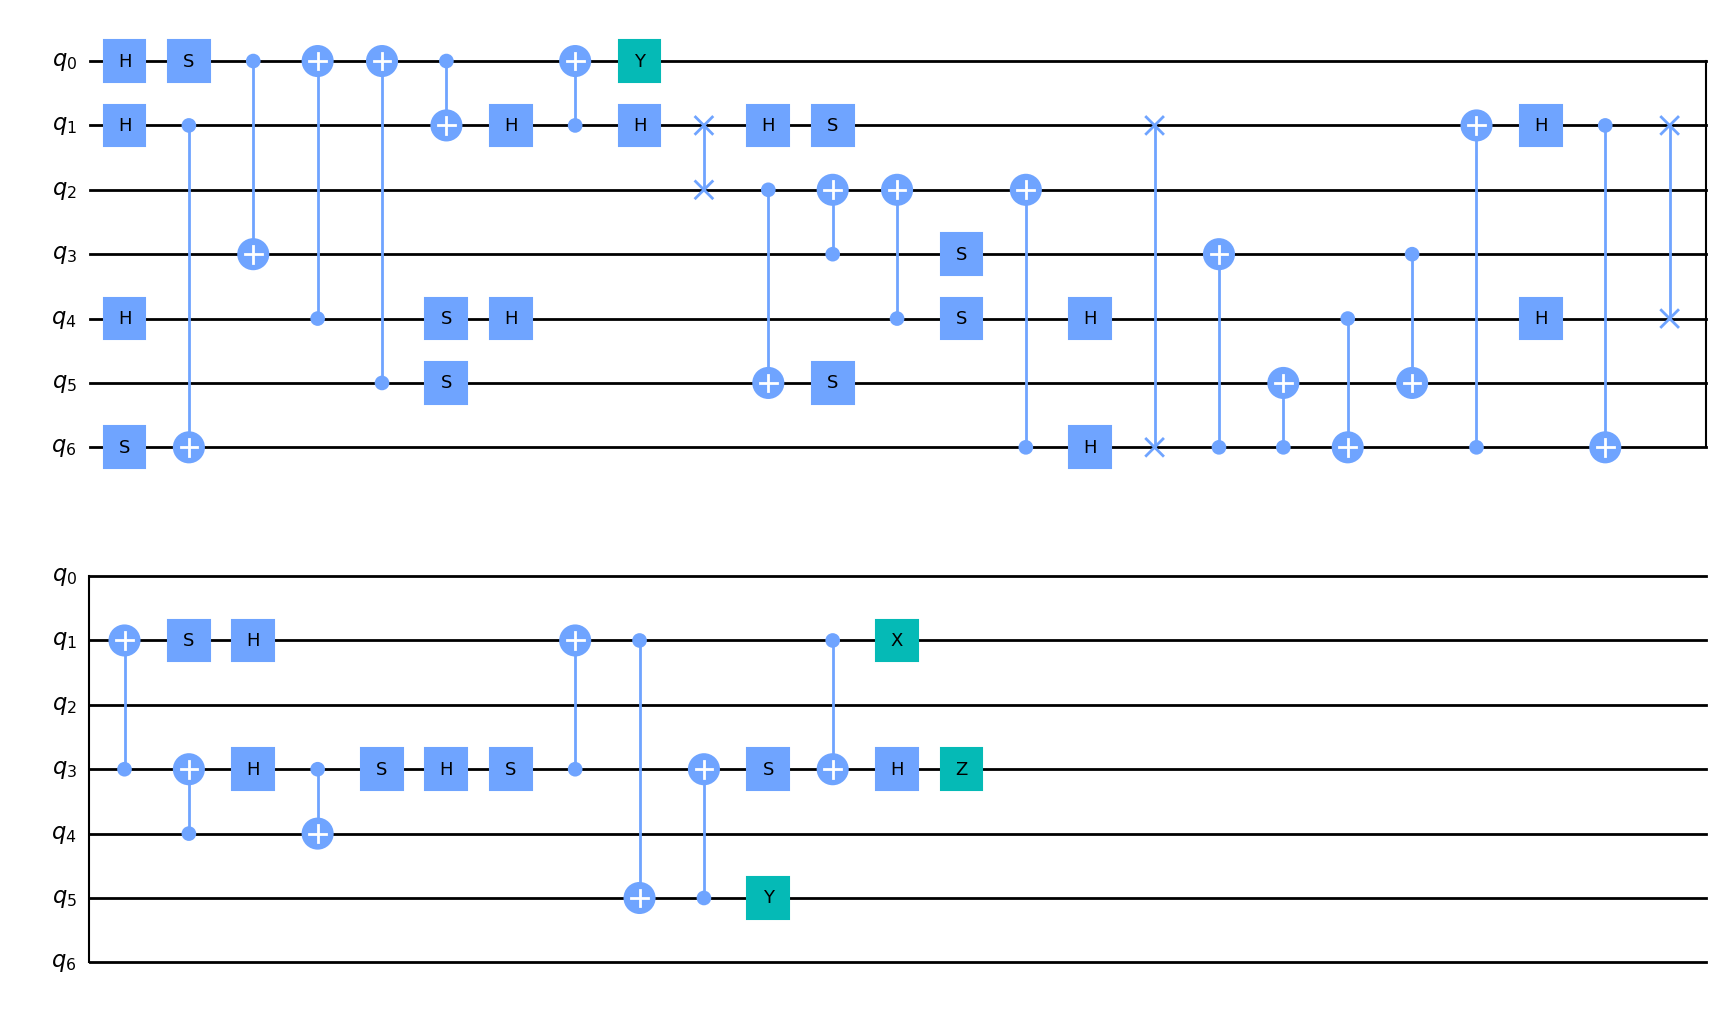

In [330]:
#create dummy ciruit with num_qubits and num_depth

num_qubits = 7
num_reps = 5
seed = 123

rand_circ = QuantumCircuit(num_qubits)
U = random_clifford(num_qubits,seed=seed)
U = U.to_circuit()
rand_circ.compose(U, qubits=[0,1,2,3,4,5,6], inplace=True)
#rand_cirq.draw("mpl")
rand_circ.draw('mpl')

In [331]:
# information about graph_state_circuit
print("Depth: ", rand_circ.decompose().depth())
print("Gates: ", rand_circ.decompose().size())

Depth:  43
Gates:  63


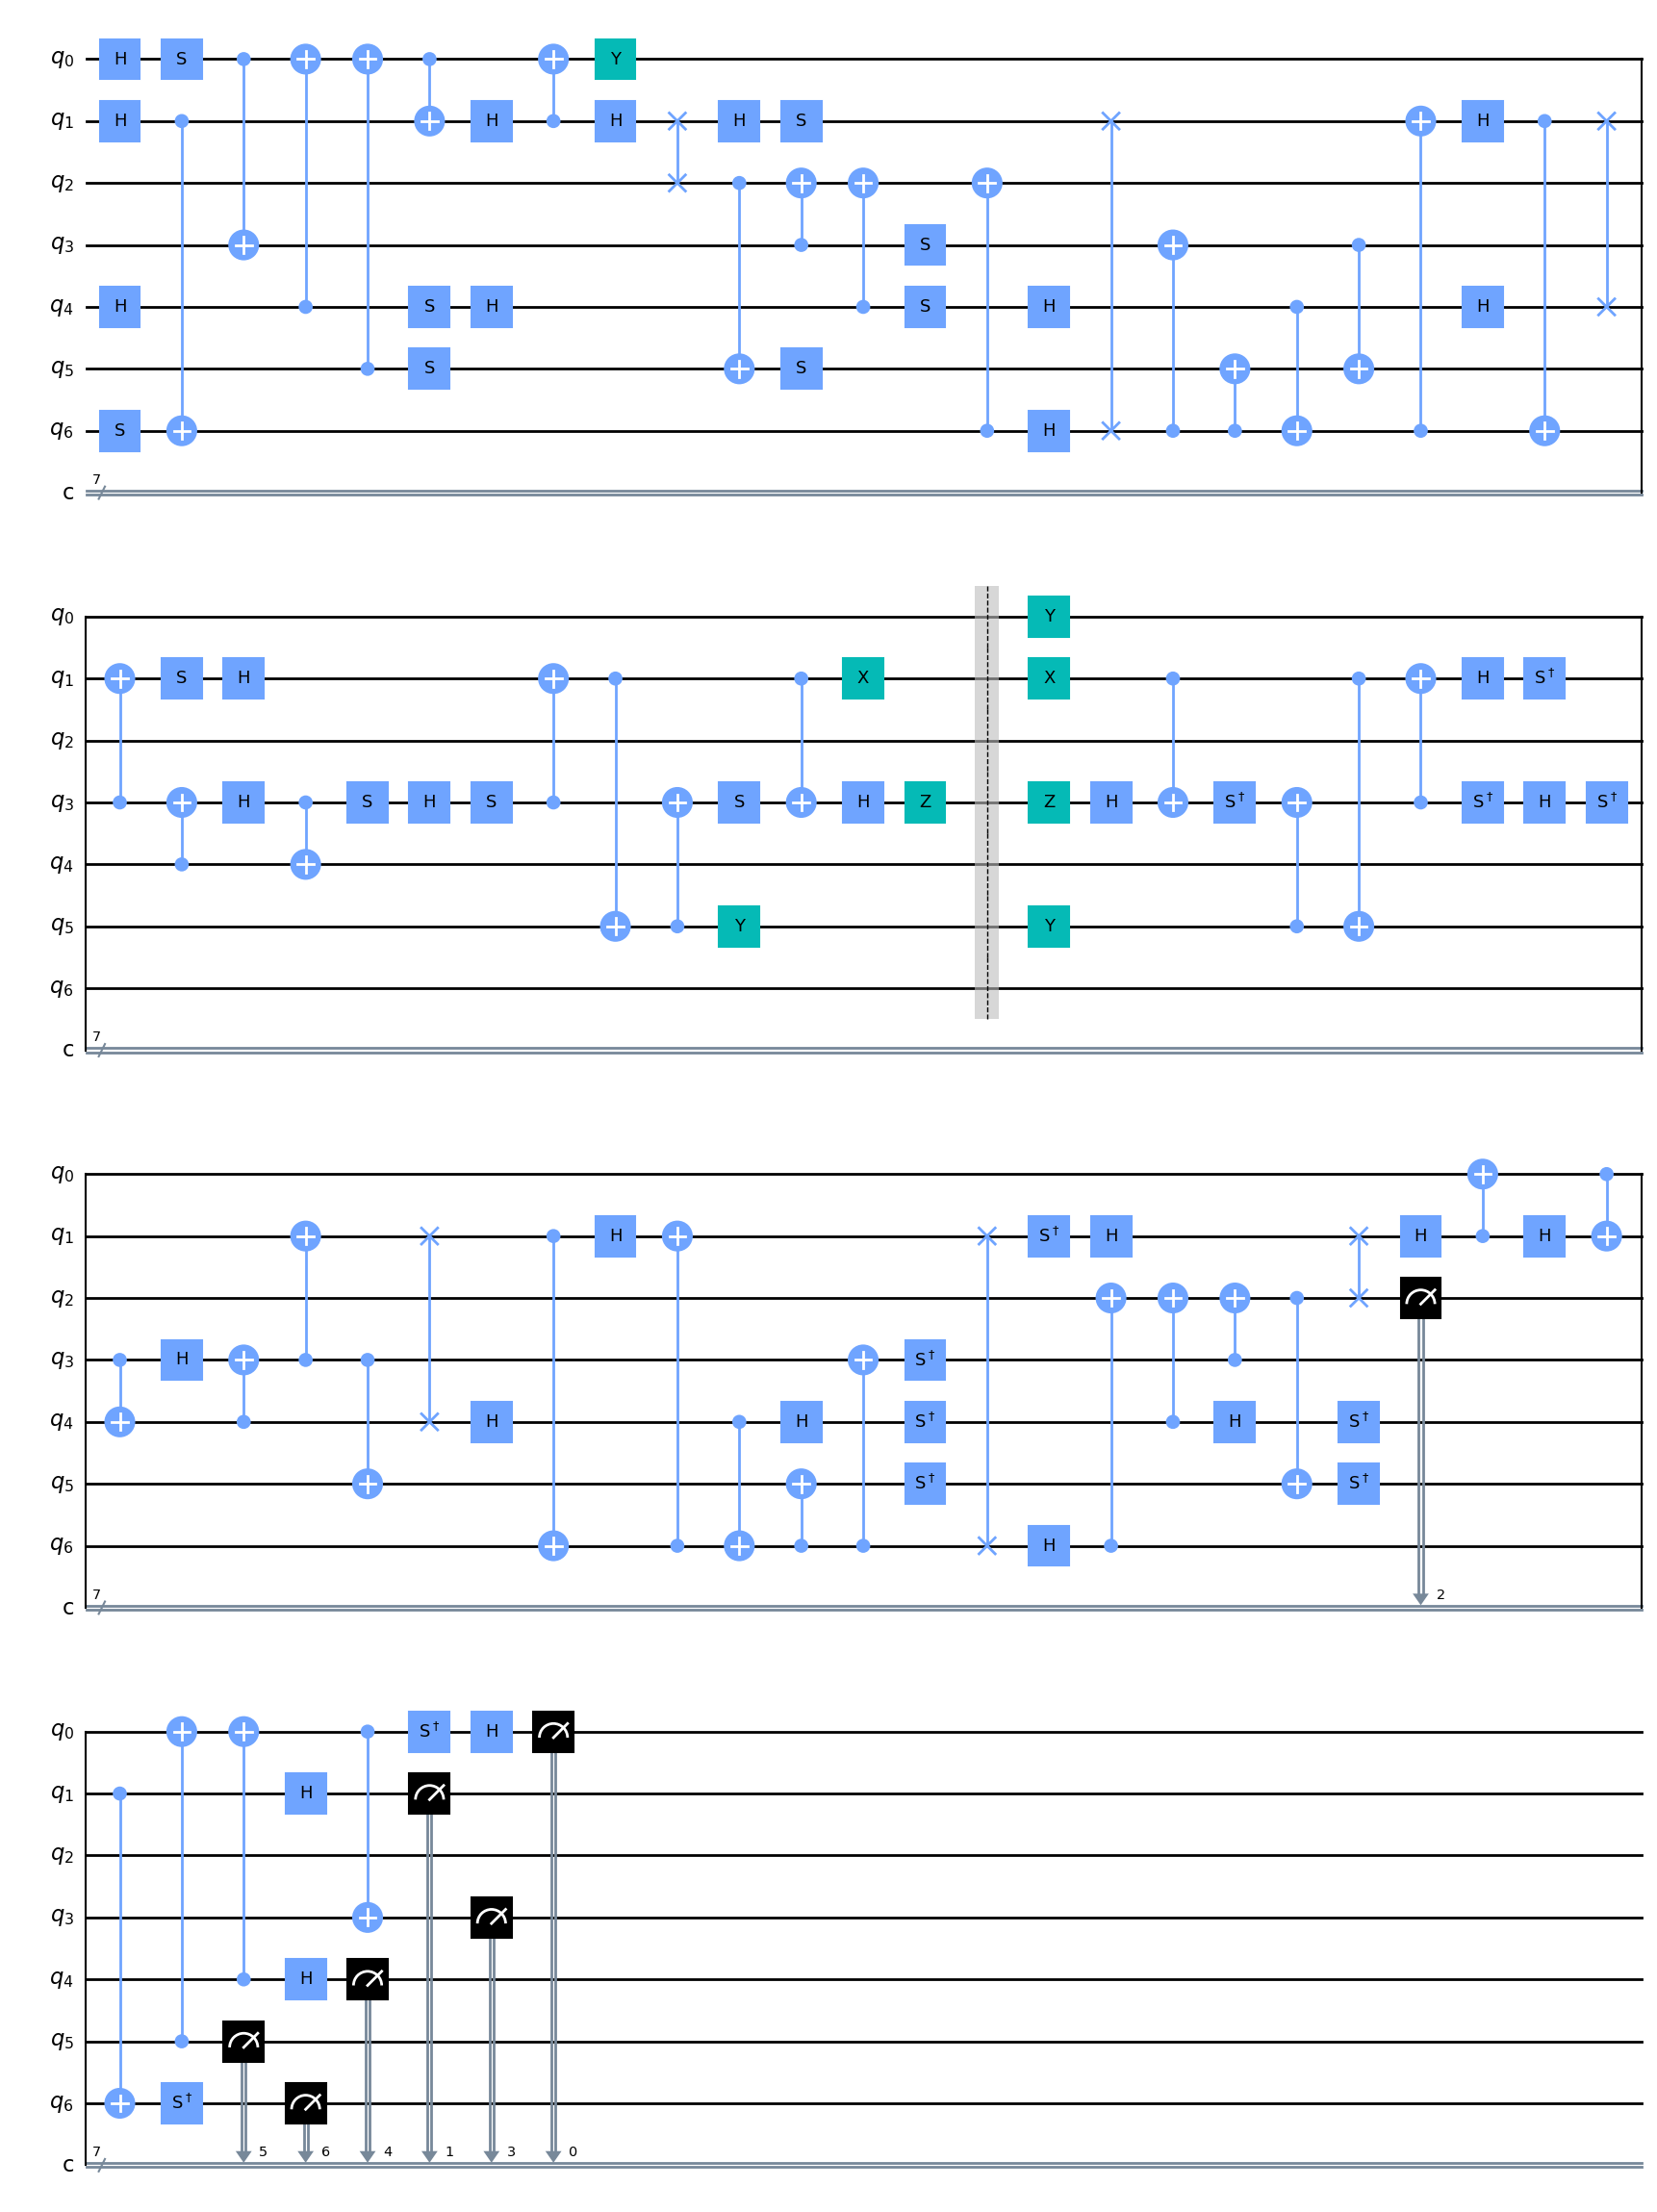

In [332]:
# now insert barrier and reverse -> result, when executing shall ideally be |0...0>
rand_circ_full = reverse_and_compose(rand_circ, num_qubits)
rand_circ_full.draw('mpl')

Now use the Clifford Ansatz to show the decreased circuit depth. 

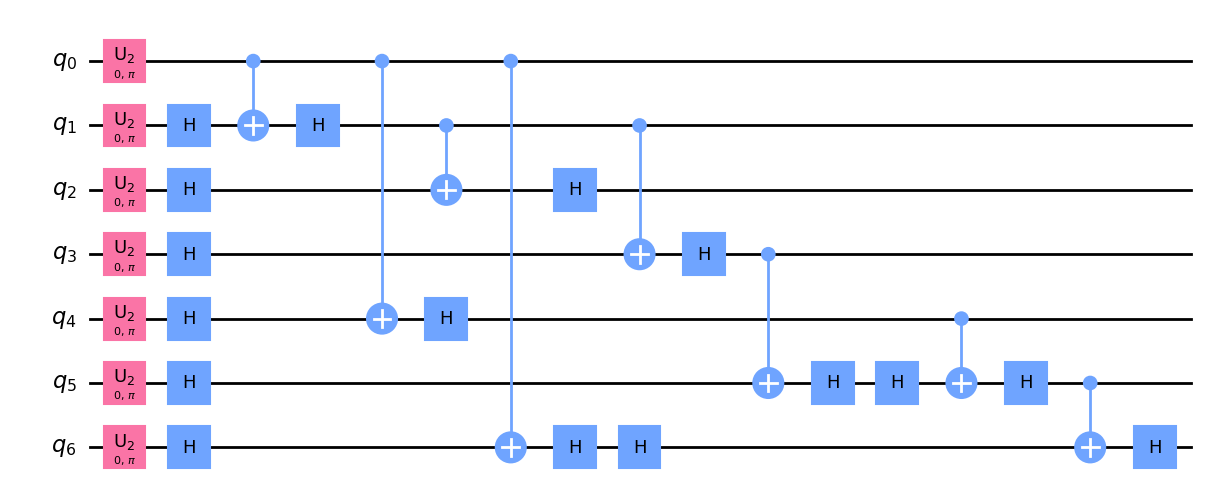

In [333]:
# adjacency matrix for `ibmq_casablanca`
adjmat = [
    [0, 1, 0, 0, 1, 0, 1], 
    [1, 0, 1, 1, 0, 0, 0], 
    [0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0, 1, 0], 
    [1, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0, 1, 1, 0, 1], 
    [1, 0, 0, 0, 0, 1, 0]]
graph_state_circuit = GS(adjmat)
graph_state_circuit.decompose().decompose().draw('mpl')

In [334]:
# information about graph_state_circuit
print("Depth: ", graph_state_circuit.decompose().decompose().depth())
print("Gates: ", graph_state_circuit.decompose().decompose().size())

Depth:  14
Gates:  31


So the depth is reduced from 43 layers to 14. 

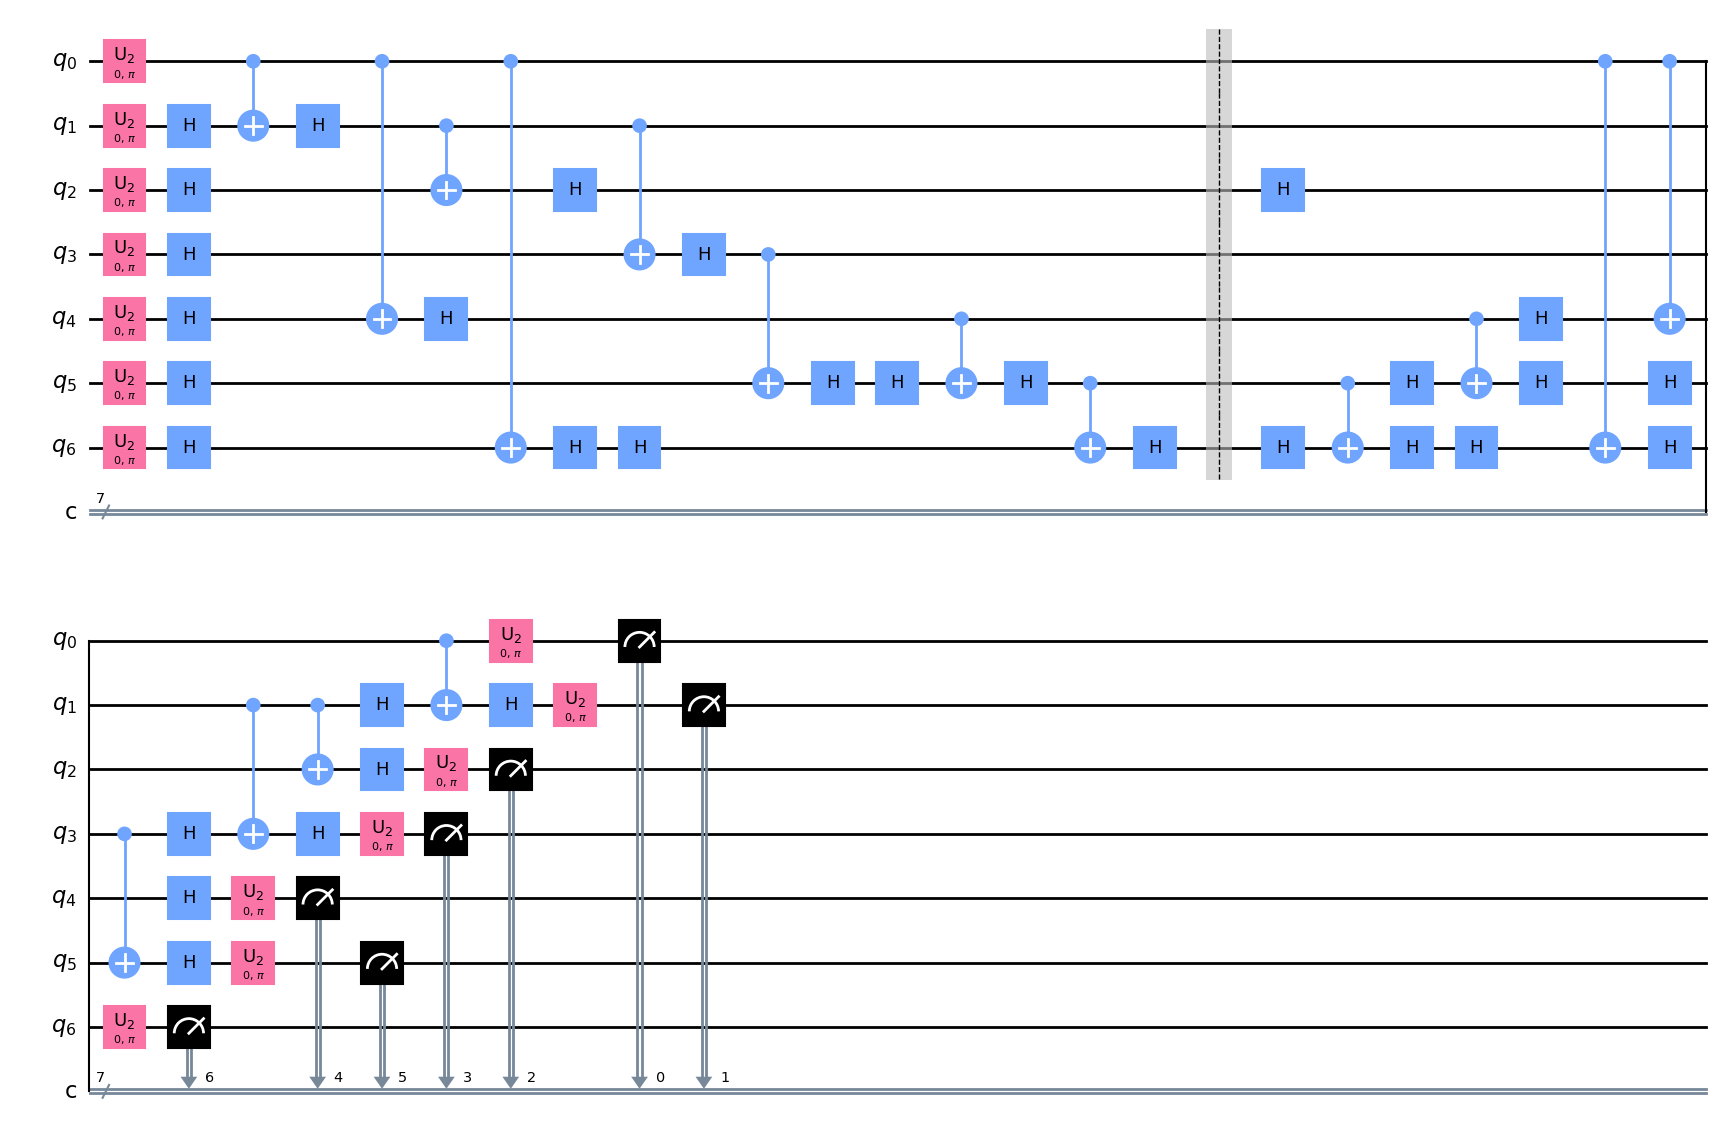

In [335]:
# now insert barrier and reverse -> result, when executing shall ideally be |0...0>
graph_state_circuit_full = reverse_and_compose(graph_state_circuit, num_qubits)
graph_state_circuit_full.decompose().decompose().draw('mpl')

Lets measure the fidelity of this (random) quantum circuit

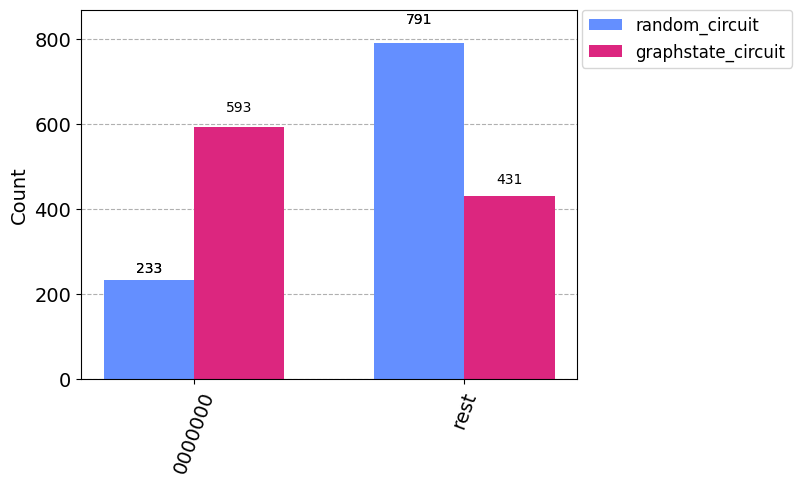

In [336]:
# now on noise hw
backend_hw = FakeHanoiV2()

job = execute([rand_circ_full, graph_state_circuit_full], backend_hw)
result = job.result()
counts_rand = result.get_counts(0)
counts_graph = result.get_counts(1)
fig, ax = plt.subplots()
plot_histogram([counts_rand, counts_graph], legend=['random_circuit','graphstate_circuit'], ax = ax, number_to_keep=1)


We see that with the graphstate circuit (Clifford Ansatz), we end in most cases in our initial zero (000000) state than with the classic random circuit. Thus, we show that lower circuit depth leads to higher fidelity and further, decreasing the depth with Clifford can improve our result quality. As our motivation is clear at this point, we introduce our solution in the following. 

## Solution


First, we calculate the "optimal" time step $\Delta t$, such that for the largest Hamiltonian coefficient $max_i |a_i|$ we have $max_i |a_i| \cdot \Delta t = \pi$.

In [337]:
def get_time_step(coeffs: list):
  """
  Returns the optimal timestep for a given list of coefficients.

  :param coeffs: list of Hamiltonian coefficients
  :return: optimal timestep
  """

  max_coeff = np.max(np.abs(coeffs))
  dt = np.pi /  max_coeff

  return dt

In the typical quantum circuits for quantum dynamics, the only non-Clifford gates are parametrized $R_z$ gates, where the arguments are $a_i \Delta t$. With the timestep from above, we make sure that $a_i \Delta t \in [-\pi, \pi]$. For the particular angles $-\pi, -\pi/2, 0, \pi/2, \pi$, these rotations correspond to Clifford gates. For an arbitrary hamiltonian, one is most likely not able to find $\Delta t$ such that all rotations can be described in terms of Clifford gates. Here, we introduce an approximation. For $a_i \Delta t$, we assign one of the neighboring Clifford gates, where the propability depends on the distance to the neighbor. For instance, an angle of $3\pi/4$ gets rounded to either $\pi/2$ or $\pi$ with equal probability. However, an angle of $7\pi/8$ is more likely to get rounded to $\pi$ than $\pi/2$. This way, we assign a rotation angle from $[-\pi, -\pi/2, 0, \pi/2, \pi]$ to every $a_i \Delta t \in [-\pi, \pi]$. These are stored as integers between -2 and 2.

In [338]:
def get_clifford_codes(coeffs, dt):
  """
  Computes a list of Clifford gates for a given list of coefficients scaled with the timestep dt.

  :param coeffs: Hamiltonian coefficients
  :param dt: optimal timestep (calculated using the previous method)
  :return: list of Clifford gates, encoded as integers between -2 and 2
  """

  new_coeffs = coeffs * dt / np.pi * 2
  clifford_codes = np.ceil(new_coeffs)

  probabilities = clifford_codes - new_coeffs

  for index, (code, prob) in enumerate(zip(clifford_codes, probabilities)):

    rn = np.random.uniform()

    if rn < prob:
      clifford_codes[index] -= 1

  return clifford_codes

Next, our algorithm introduces some additional randomness to exit inconvenient subspaces of the stabilizer state space. For each Hamiltonian coefficient $a_i$, we compute $|a_i|/max_i |a_i|$, giving us a value between 0 and 1. This value will later correspond to the probability with which we ignore the corresponding term of the Hamiltonian in our time evolution circuit. Therefore, small coefficients are likely to be ignored.

In [339]:
def get_coeff_probabilities(coeffs):
  """
  Computes the probabilities for a list of coefficients.

  :param coeffs:
  :return: list of probabilites
  """

  abs_coeffs = np.abs(coeffs)
  max_coeff = np.max(abs_coeffs)

  probabilities = abs_coeffs/max_coeff

  return probabilities

The next function implements the quantum circuit emulating $e^{-i/2 P \Delta t}$ where $P$ is an arbitrary Pauli string. Here, we use the convenient "star+ancilla" layout, where every non-identity Pauli qubit is entangled with an ancilla qubit. This way, the $R_z$ rotation can always be executed on the ancilla qubit. However, instead of arbitrary $R_z$ rotations, only $S^\dagger, S, Z$ and identity gates can occur due to our previous rescaling of the Hamiltonian coefficients. This way, the entire circuit can be described entirely in terms of Clifford gates.

In [340]:
def get_pauli_exponential_circuit(string, code):
  """
  Returns the time evolution circuit for a pauli string, where the R_z rotation is replaced by a Clifford gate given by the code.

  :param string: Pauli string
  :param code: Clifford gate code
  :return: Clifford quantum circuit
  """

  N = len(string)

  qc = QuantumCircuit(N+1)

  for i, char in enumerate(string[::-1]):
    if char == "X":
      qc.h(i)
    elif char == "Y":
      qc.s(i)
      qc.h(i)

  for i, char in enumerate(string[::-1]):
    if char != "I":
      qc.cx(i, N)

  if code == -2:
    qc.z(N)
  elif code == -1:
    qc.s(N)
  elif code == 0:
    qc.id(N)
  elif code == 1:
    qc.sdg(N)
  elif code == 2:
    qc.z(N)

  for i, char in enumerate(string[::-1]):
    if char != "I":
      qc.cx(i, N)

  for i, char in enumerate(string[::-1]):
    if char == "X":
      qc.h(i)
    elif char == "Y":
      qc.h(i)
      qc.sdg(i)

  return qc

Now that we have a function to evolve by a single Pauli string, we need another function to append the circuits for all the strings. As described previously, a string $P_i$ may be completely skipped with a probability $p_i = |a_i|/max_i|a_i|$.

In [341]:
def hamiltonian_to_pauli_exponential_circuit(strings, codes, probabilities):
  """
  Appends the quantum circuits for all the pauli strings. String can be skipped according to the probability list.

  :param strings: pauli strings
  :param codes: clifford gate codes
  :param probabilities: skipping probabilities
  :return: clifford circuit
  """

  qc = None

  for string, code, prob in zip(strings, codes, probabilities):

    rn = np.random.uniform()

    if rn <= prob:
      if not qc:
        qc = get_pauli_exponential_circuit(string, code)

      else:
        qc = qc.compose(get_pauli_exponential_circuit(string, code))

    # qc.barrier()
  return qc

The Clifford circuits for time evolution can be efficiently compressed by exploiting the fact, that these circuit create stabilizers states. Here, we make use of the graph state representation of stabilizer states. The next function takes a qiskit quantum circuit and converts to the graph state representation of a stabilizer state. The simulation is based on the https://github.com/libtangle/graph-state package.

In [342]:
def circuit_to_graph_state(circuit: QuantumCircuit):
  """
  Converts a quantum circuit to a graph state.

  :param circuit: qiskit clifford quantum circuit
  :return: graph state
  """

  G = GraphState(circuit.num_qubits)

  for instruction in circuit.data:
    name = instruction.operation.name
    qubits = instruction.qubits
    indices = [circuit.qregs[0].index(qubit) for qubit in qubits]

    if name == "h":
      G.h(indices[0])
    elif name == "s":
      G.s(indices[0])
    elif name == "sdg":
      G.s_dagger(indices[0])
    elif name == "z":
      G.z(indices[0])

    elif name == "cx":
      G.h(indices[1])
      G.cz(control=indices[0], target=indices[1])
      G.h(indices[1])

  G.vertices.pop(-1)

  return G

By converting the graph state back to a quantum circuit, we can greatly reduce the circuit depth in comparison to the initial circuit. For this, we need a function that converts the vertex operators (VOPs) back to a sequence of Clifford gates.

In [343]:
def vop_to_gates(vop):
  """
  Converts vop code to list of Clifford gates.

  :param vop: vertex operator code
  :return: list of CLifford operators
  """

  gates = []

  if vop == 0:
    gates = ["id"]
  elif vop == 1:
    gates = ["x"]
  elif vop == 2:
    gates = ["y"]
  elif vop == 3:
    gates = ["z"]
  elif vop == 4:
    gates = ["x", "sdg"]
  elif vop == 5:
    gates = ["sdg"]
  elif vop == 6:
    gates = ["s"]
  elif vop == 7:
    gates = ["x", "s"]
  elif vop == 8:
    gates = ["h", "y"]
  elif vop == 9:
    gates = ["h", "x"]
  elif vop == 10:
    gates = ["h"]
  elif vop == 11:
    gates = ["h", "z"]
  elif vop == 12:
    gates = ["s", "h", "sdg"]
  elif vop == 13:
    gates = ["sdg", "h", "s"]
  elif vop == 14:
    gates = ["s", "h", "s"]
  elif vop == 15:
    gates = ["sdg", "h", "sdg"]
  elif vop == 16:
    gates = ["sdg", "h"]
  elif vop == 17:
    gates = ["s", "x", "h"]
  elif vop == 18:
    gates = ["s", "y", "h"]
  elif vop == 19:
    gates = ["s", "h"]
  elif vop == 20:
    gates = ["h", "s"]
  elif vop == 21:
    gates = ["h", "sdg"]
  elif vop == 22:
    gates = ["h", "x", "sdg"]
  elif vop == 23:
    gates = ["h", "y", "sdg"]

  return gates

Now that we can convert the vertex operators back to our gate model, we still have to prepare the graph state in terms of a quantum circuit. First, all qubits are prepared in the $\left|+\right>$ state by applying Hadamard gates. Then, all edges between qubits are implemented as controlled-$Z$ gates. Last, the vertex operators are applied.

In [344]:
def graph_state_to_circuit(G: GraphState):
  """
  Converts graph state back to quantum circuit.

  :param G: Graph state
  :return: quantum circuit
  """

  num_qubits = len(G.vertices)

  qc = QuantumCircuit(num_qubits)

  # Prepare qubit in |+> state
  for i in range(num_qubits):
    qc.h(i)

  # Apply CZ for every edge
  for edge in G.edges():
    qc.cz(edge[0], edge[1])

  # Apply vertex operators
  for index, vertex in enumerate(G.vertices):
    gates = vop_to_gates(vertex.vop_code)
    for gate in gates:
      qc.__getattribute__(gate)(index)

  return qc

Finally, we utilize all the previous functions in our final function, which approximates the ground state of the system based entirely on stabilizer states. For a given s, we approximate the time evolution of $H(s) = (1-s) H_0 + s H_{mixer}$ by a time step $\Delta t$ chosen according to the principle from above. As through our probabilistic algorithm we get "random" circuits, it is convenient to repeat the procedure multiple times and simply select the best circuit. We want to emphasize that the energy of the stabilizer state can be calculated efficiently on a classical computer. Therefore, our classical pre-optimization routine implies no bottleneck on our algorithm.

In [345]:
def approximate_ground_state(s, H0_strs, H0_coeffs, HInt_strs, HInt_coeffs, shots):

  all_strings =  HInt_strs + H0_strs
  all_coeffs = np.array(list(s * HInt_coeffs) + list((1-s) * H0_coeffs))

  best_graph = None
  best_ev = None
  best_qc = None

  for _ in range(shots):
    dt = get_time_step(all_coeffs)
    clifford_codes = get_clifford_codes(all_coeffs, dt)
    probabilities = get_coeff_probabilities(all_coeffs)

    qc = hamiltonian_to_pauli_exponential_circuit(all_strings, clifford_codes, probabilities)
    # qc = qc_gs.compose(qc_te)

    G = circuit_to_graph_state(qc)

    # AT THIS POINT, WE WOULD LOVE TO OPTIMIZE THE GRAPH STATES USING LOCAL COMPLEMENTATION. UNFORTUNATELY THE PACKAGE IS FULL OF BUGS AND LOCAL COMPLEMENTATION DOES NOT WORK PROPERLY.

    qc = graph_state_to_circuit(G)
    # qc.draw("mpl")

    stabilizer_state = StabilizerState(qc)

    string_evs = [stabilizer_state.expectation_value(Pauli(string)) for string in HInt_strs]

    ev = np.sum(string_evs * HInt_coeffs)

    if not best_ev or ev < best_ev:
      best_ev = ev
      best_graph = G
      best_qc = qc

  return best_ev, best_qc, best_graph

Here, we test the minimalistic example of a chain of three coupled spins. As the ground state of the Ising model is a stabilizer state, we even manage to prepare the exact ground state using our "heuristic" approximation. We further observe that we typically find optimal solutions in the range $s \in [0.5, 0.7]$. With this mixing, the free and interaction hamiltonians are approximately equally weighted, which means that all pauli strings contribute with almost equal probability.

We start with our basic example as above: $H_0 = Z_0Z_1$ and $H_{mixer} = X_0X_1$

In [346]:
HInt_strs = ["ZZ"]
HInt_coeffs = np.array([1])
H0_strs = ["XI", "IX"]
H0_coeffs = np.array([-1, -1])


s_list = np.linspace(0.1, 0.7, 10)

evs = []

for s in s_list:
  ev, qc, G = approximate_ground_state(s, H0_strs=H0_strs, H0_coeffs=H0_coeffs, HInt_strs=HInt_strs, HInt_coeffs=HInt_coeffs, shots= 20)
  evs.append(ev)

# min(evs)
#HInt = SparsePauliOp(data=["ZZ"], coeffs=np.array([2]))
#H0 = SparsePauliOp(data=["XI", "IX"], coeffs=np.array([-1, -1]))

[1, 1, 1, 1, 1, 1, 1, -1, -1, 1]


Text(0.5, 0, 'Coupling strength $s$')

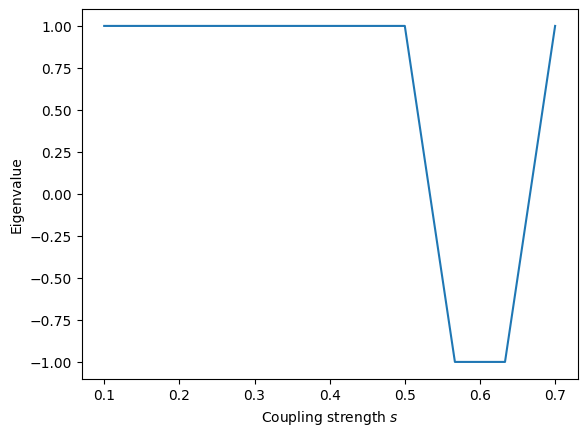

In [347]:
import matplotlib.pyplot as plt

print(evs)
plt.plot(s_list, evs)
plt.ylabel('Eigenvalue')
plt.xlabel('Coupling strength $s$')

Further, lets see for the second example: Where $H_{0} = Z_0Z_1Z_2Z_3Z_4Z_5$ 
and  $H_{mixer} =   X_0X_1X_2X_3X_4X_5$ <br>

In [348]:
HInt_strs = ["ZZZZZZ"]
HInt_coeffs = np.array([1])
H0_strs = ["XIIIII", "IXIIII", "IIXIII", "IIIXII", "IIIIXI", "IIIIIX"]
H0_coeffs = np.array([-1, -1, -1, -1, -1, -1])

s_list = np.linspace(0.3, 0.7, 10)

evs = []

for s in s_list:
  ev, qc, G = approximate_ground_state(s, H0_strs=H0_strs, H0_coeffs=H0_coeffs, HInt_strs=HInt_strs, HInt_coeffs=HInt_coeffs, shots=10)
  evs.append(ev)

# min(evs)
#HInt = SparsePauliOp(data=["ZZ"], coeffs=np.array([2]))
#H0 = SparsePauliOp(data=["XI", "IX"], coeffs=np.array([-1, -1]))

[1, 1, 1, 1, 1, 0, -1, 0, 0, 1]


Text(0.5, 0, 'Coupling strength $s$')

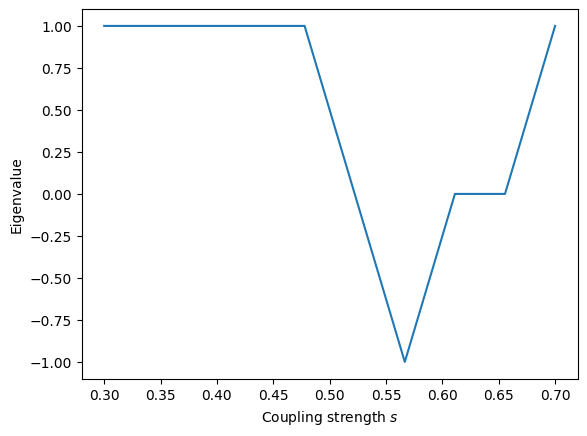

In [349]:
print(evs)
plt.plot(s_list, evs)
plt.ylabel('Eigenvalue')
plt.xlabel('Coupling strength $s$')

For both examples we see our Clifford Ansatz lead to the expected transition from Eigenvalue 1 to -1. The transition happens in both cases at $s \in[0.5, 0.7]$

## Conclusion

We showed the improvement of our naive approach, where we got as Eigenvalues for our simple Hamiltonian $H_0 = Z_0Z_1$, $EV_{without noise} = -0.999$ and  $EV_{with noise} = -0.66$. 
Or for $H_{0} = Z_0Z_1Z_2Z_3Z_4Z_5$ $EV_{without noise} = -0.94$ and  $EV_{with noise} = -0.37$, respectively. The noisy simulations lead to high costs. 

Further, we showed that a reduced circuit depth caused by the Clifford Ansatz, would lead to higher fidelity. Based on this we showed that we could improve the generation of Hamiltonian Eigenstates where we reached for some  $s \in[0.5, 0.7]$ the true solution of $EV = -1$. 

A further improvement would be, to show that this model also works for generating eigenstates of Hamiltionians which aren't based on the Ising model. 


## Outlook

While for the Ising model, the ground state can be exactly described in terms of stabilizer states, this is of course not the case for other systems. For instance, one could use our technique to approximate the highly entangled ground state of the Heisenberg model in the anti-ferromagnetic phase (inspired by the last Hackathon in BCN ;)). Due to the lack of time, we have not been able to fully test this idea. However, we have observed that our initial guess for the ground state generated by Clifford circuits outperforms random initial states in VQE algorithms. This is already a great success. Unfortunately, a better initial guess can still lead to barren plateaus and therefore be outperformed by a random initial point.
Our future idea is to use the Clifford part for the initial state of the VQE and then apply a hardware efficient ansatz. By making use of the graph state formalism (which we could not do due to bugs in the graph-sim package), the initial stabilizer state can be created with a very shallow circuit. On top of that, the graph state topology could specifically optimized with respect to the hardware topology before transforming back to the circuit model. Here, one could create equivalent stabilizer states by applying local complementation to the graph state. This technique often allows to find equivalent circuits with even less entangling gates. Such an optimization routine could be based on techniques such as simulated annealing.
So even though our algorithm is still incomplete, we are confident that a finalized version could offer advantages in the field of VQE algorithms.

Still, for Ising models our algorithm works already!